# Solving Burgers Equation with SA-PINN



## Problem Setup

Burgers equation:

$$\left\{\begin{array}{l}
u_t + uu_x = \nu u_{xx} \quad x \in [-1, 1]\newline
u(x, 0) = -\sin(\pi x) \quad x \in [-1, 1] \newline
u(t, -1) = u(t, 1) = 0
\end{array}
\right.$$
where $\nu = \frac{0.01}{\pi}$.

## Install and Import Libraries

In [ ]:
!pip install pyDOE

In [63]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from pyDOE import lhs
import tensorflow as tf
import numpy as np
import scipy.optimize
import scipy.io

np.random.seed(1234)
tf.random.set_seed(1234)

### Check GPU Status

In [ ]:
from tensorflow.python.client import device_lib
import subprocess
nvidiasmi_output = subprocess.run(['nvidia-smi', '-L'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(nvidiasmi_output)
print(device_lib.list_local_devices())

## Import Dataset and Process

In [65]:
data = scipy.io.loadmat('data/burgers_shock.mat')

In [66]:
x = data['x']
t = data['t']
usol = data['usol']

X, T = np.meshgrid(x, t)

# test set
X_u_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

lb = X_u_test[0]
ub = X_u_test[-1]

u = usol.flatten('F')[:, None]

# Training data

N_u = 100
N_f = 10000

# IC
left_x = np.hstack((X[0, :][:, None], T[0, :][:, None]))
left_u = usol[:, 0][:, None]

# BCs
bottom_x = np.hstack((X[:, 0][:, None], T[:, 0][:, None]))
bottom_u = usol[-1, :][:, None]

top_x = np.hstack((X[:, -1][:, None], T[:, 0][:, None]))
top_u = usol[0, :][:, None]

all_X_u_train = np.vstack([left_x, bottom_x, top_x])
all_u_train = np.vstack([left_u, bottom_u, top_u])

# choose random N_u points for training
idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False)

X_u_train = all_X_u_train[idx, :]
u_train = all_u_train[idx, :]

# Collocation Points(PDE)

# Latin Hypercube sampling for collocation points
X_f_train = lb + (ub - lb) * lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train)) # 把边界点也加进pde的训练集中

## Define SA-PINN Model

In [5]:
class SAPINN(tf.Module):
    """
    Define a SA-PINN for approximation the solution of burgers equation.

    Params:
      layers: an array of each layer's width(num of neurons)
      lb: [xmin, tmin],
      ub: [xmax, tmax]
    """
    def __init__(self, layers, lb, ub):
        self.weights = [] # list of model's parameters(weights and bias)
        self.parameters_num = 0 # numbers of model's parameters
        self.layers = layers
        self.lb = lb
        self.ub = ub
        self.epoch = 0 

        # setup model weights
        for i in range(len(layers)-1):
            input_dim = layers[i]
            output_dim = layers[i+1]

            std = np.sqrt(2 / (input_dim + output_dim))

            w_value = tf.random.normal([input_dim, output_dim], stddev=std, dtype='float64')
            w = tf.Variable(w_value, trainable=True, name=f'w{i+1}')
            self.weights.append(w)

            b_value = tf.zeros([output_dim, ], dtype='float64')
            b = tf.Variable(b_value, trainable=True, name=f'b{i+1}')
            self.weights.append(b)

            # num += num_of_weight + num_of_bias
            self.parameters_num += input_dim * output_dim + output_dim
    
        # self-adaptive weights

        ## boundary weights
        self.u_weights = tf.Variable(tf.ones([N_u, 1], dtype="float64"), trainable=True, name='boundary_weight')

        ## residual weights
        self.f_weights = tf.Variable(tf.ones([N_f+N_u, 1], dtype='float64'), trainable=True, name='pde_weight')

    def __call__(self, X):
        """
        Define forward pass, i.e. use model to predict the result

        Params:
          X: the dataset, that will be used to predict
        """
        x = X
        x = (x - self.lb) / (self.ub - self.lb)

        # applying activation function
        for i in range(len(self.layers)-2):
            # x = activation_function(wx + b)
            x = tf.nn.tanh(tf.add(tf.matmul(x, self.weights[2*i]), self.weights[2*i+1]))

        # output layer(without activation function)
        x = tf.add(tf.matmul(x, self.weights[-2]), self.weights[-1])
        return x

    def loss_BC_IC(self, X_u_train, u_train):
        """
        Calculate the loss score of boundary condition and initial condition

        Params:
          X_u_train: training set of boundary condition and initial condition
          u_train: exact `u` value at the BC/IC training set (since we have the data of `u`, we can use part of it to train model)
        """

        # element-wise multiply by adaptive weights of boundary
        loss_u = self.u_weights * (u_train - self(X_u_train))
        loss_u = tf.reduce_mean(tf.square(loss_u))
        return loss_u

    def loss_PDE(self, X_f_train):
        """
        Calculate the loss score of PDE

        Params: 
          X_f_train: trainning set of PDE as well as BC/IC (I've concatenated them above)
        """
    
        X = tf.Variable(X_f_train, dtype = 'float64', trainable=False)
    
        nu = 0.01/np.pi

        x_f = X[:, 0:1]
        t_f = X[:, 1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            # tf.stack([x_f[:, 0], t_f[:, 0]], axis=1) <=> X
            # It's been destructured then stacked because we need the gradients of x and t
            X = tf.stack([x_f[:, 0], t_f[:, 0]], axis=1)   

            u = self(X)
            u_x = tape.gradient(u, x_f)

        u_t = tape.gradient(u, t_f)    
        u_xx = tape.gradient(u_x, x_f)

        del tape

        # f: residual of pde
        f = u_t + (u)*(u_x) - (nu)*u_xx

        # element-wise multiply by adaptive weights of residual
        loss_f = tf.reduce_mean(tf.square(self.f_weights * f))

        return loss_f

    def loss(self, X_u_train, u_train, X_f_train):

        """
        Calculate total loss of the model

        Params:
          X_u_train: training set of boundary condition and initial condition
          u_train: exact `u` value at the BC/IC training set
          X_f_train: trainning set of PDE as well as BC/IC
        """

        loss_u = self.loss_BC_IC(self.X_u_train, self.u_train)
        loss_f = self.loss_PDE(self.X_f_train)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f

    def set_training_set(self, X_u_train, u_train, X_f_train):
        """
        set training set for the model.

        X_u_train: training set of boundary condition and initial condition
        u_train: exact `u` value at the BC/IC training set
        X_f_train: trainning set of PDE as well as BC/IC
        """
        
        self.X_u_train = X_u_train
        self.u_train = u_train
        self.X_f_train = X_f_train

    def get_weights(self):
        """
        Return a 'long' tensor of model weights' current value
        """

        long_weights_tensor = []

        for i in range(len(self.layers)-1):
            # flatten weights and biases
            w_1d = tf.reshape(self.weights[2*i], [-1]) 
            b_1d = tf.reshape(self.weights[2*i+1], [-1])

            # then concatenate them into a single tensor
            long_weights_tensor = tf.concat([long_weights_tensor, w_1d], axis=0)
            long_weights_tensor = tf.concat([long_weights_tensor, b_1d], axis=0)

        return long_weights_tensor

    def set_weights(self, parameters):
        """
        Set model weights, given new weights values(stored in parameters)

        Params:
          parameters: a "long" tensor of new model weights, whose size and shape fit `long_weights_tensor` defined in self.get_weights()
        """

        # Since `parameters` is a long tensor, we have to destructure it to update model weights.
        # To do that, we need shape and size of each weight and bias

        for i in range(len(self.layers)-1):
            w_shape = tf.shape(self.weights[2*i]).numpy()
            w_size = tf.size(self.weights[2*i]).numpy()

            # pick new weight in `parameters`
            new_w = parameters[0:w_size]
            self.weights[2*i].assign(tf.reshape(new_w, w_shape))
            parameters = np.delete(parameters, np.arange(w_size), axis=0) # delete this part from `parameters`, so we can get next bias from index 0

            b_shape = tf.shape(self.weights[2*i+1]).numpy()
            b_size = tf.size(self.weights[2*i+1]).numpy()

             # pick new bias in `parameters`
            new_b = parameters[0:b_size]
            self.weights[2*i+1].assign(tf.reshape(new_b, b_shape))
            parameters = np.delete(parameters, np.arange(b_size), axis=0) # delete this part from `parameters`, so we can get next weight from index 0

    def optimizer_func(self, parameters):
        """
        Define an optimizer function for scipy's l-bfgs optimizer

        Params:
          parameters: a "long" tensor of new model weights, whose size and shape fit `long_weights_tensor` defined in self.get_weights()

        Returns:
          loss.numpy(): loss score of the model
          gradients_1d.numpy(): a numpy array of gradients
        """

        self.set_weights(parameters) # set new weights

        with tf.GradientTape() as tape:
            tape.watch(self.weights)
            
            # loss after update
            loss, loss_u, loss_f = self.loss(self.X_u_train, self.u_train, self.X_f_train)

        gradients = tape.gradient(loss, self.weights)

        del tape

        gradients_1d = [] # flatten gradients, like `long_weights_tensor` defined in self.get_weights()

        for i in range(len(self.layers)-1):
            # flatten gradients of weights and biases
            gradients_w_1d = tf.reshape(gradients[2*i], [-1]) 
            gradients_b_1d = tf.reshape(gradients[2*i+1], [-1])

            # then concatenate them into a single tensor
            gradients_1d = tf.concat([gradients_1d, gradients_w_1d], 0) 
            gradients_1d = tf.concat([gradients_1d, gradients_b_1d], 0)

        return loss.numpy(), gradients_1d.numpy()

    def optimizer_callback(self, parameters):
        """
        Define an optimizer callback function
        """

        loss, loss_u, loss_f = self.loss(self.X_u_train, self.u_train, self.X_f_train)

        # calculate L2 error at this epoch
        u_pred = self(X_u_test)
        L2_error = np.linalg.norm((u - u_pred), 2) / np.linalg.norm(u, 2)

        # print loss, loss_u, loss_f, L2_error at this epoch
        self.epoch += 1
        tf.print(f"epoch: {self.epoch} loss:{loss:.5f} loss_u: {loss_u:.5f} loss_f: {loss_f:.5f} L2_error: {L2_error:.5f}")

    def adaptive_gradients(self):
        """
        Calculate model weights' gradients, as well as adaptive weights' gradients
        """

        with tf.GradientTape() as tape:
            tape.watch(self.weights)

            loss, loss_u, loss_f = self.loss(self.X_u_train, self.u_train, self.X_f_train)

        # gradients of model' weights
        gradients = tape.gradient(loss, self.weights)

        del tape

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.u_weights)
            tape.watch(self.f_weights)

            loss, loss_u, loss_f = self.loss(self.X_u_train, self.u_train, self.X_f_train)

        # gradients of adaptive weiths
        gradient_u_weights = tape.gradient(loss, self.u_weights)
        gradient_f_weights = tape.gradient(loss, self.f_weights)

        del tape

        return loss, gradients, gradient_u_weights, gradient_f_weights

## Load Model

Load model from previously saved model. (See **Save Model below**)

In [70]:
import json

model_path = 'models/burgers_SAPINN_model.json'

In [7]:
def load_model(model_path):
    """
    return an trained SA-PINN model for burgers equation
    
    params:
      model_path: path of json file that contains model's data
    """
    
    with open(model_path, 'r') as f:
        model_data = json.load(f)
        f.close()
    
    # data
    layers = np.array(model_data['layers'])
    model_weights = np.array(model_data['model_weights'])
    model_adaptive_weights = model_data['model_adaptive_weights']

    model =  SAPINN(layers, lb, ub) # SAPINN, lb, ub must be defined before you load the model
    model.set_training_set(X_u_train, u_train, X_f_train) # X_u_train, u_train, X_f_train must be defined before you load the model
    model.set_weights(model_weights)
    model.u_weights.assign(np.array(model_adaptive_weights[0]))
    model.f_weights.assign(np.array(model_adaptive_weights[1]))
    
    return model

## Define Plot Function

In [18]:
def solutionplot(u_pred,X_u_train,u_train):
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,usol.T[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.25s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75s$', fontsize = 10)
     

## Train the Model

In [ ]:
# setup model
layers = np.array([2, 32, 64, 32, 1])
sa_pinn = SAPINN(layers, lb, ub)
sa_pinn.set_training_set(X_u_train, u_train, X_f_train)

# firstly, use Tensorflow Adam optimizer to apply gradient descent/ascent
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
optimizer_u_weight = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
optimizer_f_weight = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

adam_epochs = 5000
print("Starting Adam training")
for epoch in range(adam_epochs):

    loss, gradients, gradient_u_weights, gradient_f_weights = sa_pinn.adaptive_gradients()


    print(f"epoch: {epoch+1} loss: {loss.numpy():.5f}")

    # apply gradient descent on model weights
    optimizer.apply_gradients(zip(gradients, sa_pinn.weights))
    # apply gradient ascent on adaptive weights
    optimizer_u_weight.apply_gradients(zip([-gradient_u_weights], [sa_pinn.u_weights]))
    optimizer_f_weight.apply_gradients(zip([-gradient_f_weights], [sa_pinn.f_weights]))

# then, use scipy l-bfgs optimizer to train model
lbfgs_epochs = 5000
print("Starting L-BFGS training")
options = {
    'disp': None,
    'maxcor': 200, 
    'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
    'gtol': 5e-8, 
    'maxfun':  50000, 
    'maxiter': lbfgs_epochs,
    'iprint': -1,   #print update every 50 iterations
    'maxls': 50}

results = scipy.optimize.minimize(
    fun=sa_pinn.optimizer_func,
    x0=sa_pinn.get_weights().numpy(),
    args=(),
    method='L-BFGS-B',
    jac=True,
    callback=sa_pinn.optimizer_callback,
    options=options
)

## Print and Plot Results

In [ ]:
print(results)
sa_pinn.set_weights(results.x)

Test set L2 error: 0.072394


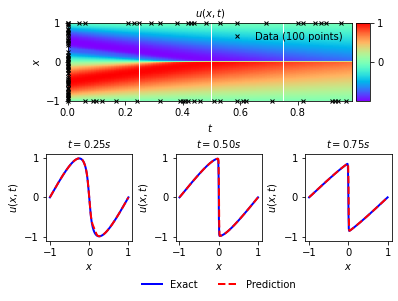

In [80]:
# L2 error of the model
u_pred = sa_pinn(X_u_test).numpy()
L2_error = np.linalg.norm((u - u_pred), 2) / np.linalg.norm(u, 2)
print(f'Test set L2 error: {L2_error:5f}')

u_pred = np.reshape(u_pred,(256,100),order='F') 
''' Solution Plot '''
solutionplot(u_pred,X_u_train,u_train)

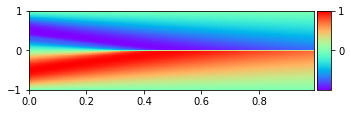

In [68]:
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
              extent=[T.min(), T.max(), X.min(), X.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

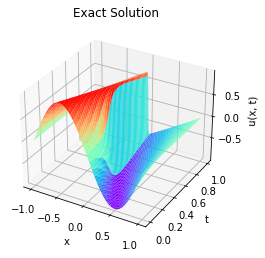

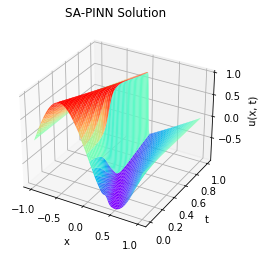

In [83]:
ax = plt.axes(projection='3d')
ax.plot_surface(X, T, u.reshape((100, 256)), cmap='rainbow')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x, t)')
ax.set_title('Exact Solution')
plt.show()

ax = plt.axes(projection='3d')
ax.plot_surface(X, T, u_pred.T, cmap='rainbow')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x, t)')
ax.set_title('SA-PINN Solution')
plt.show()

Text(0.5, 0.98, 'SA-PINN Solution v.s. Exact solution at different time')

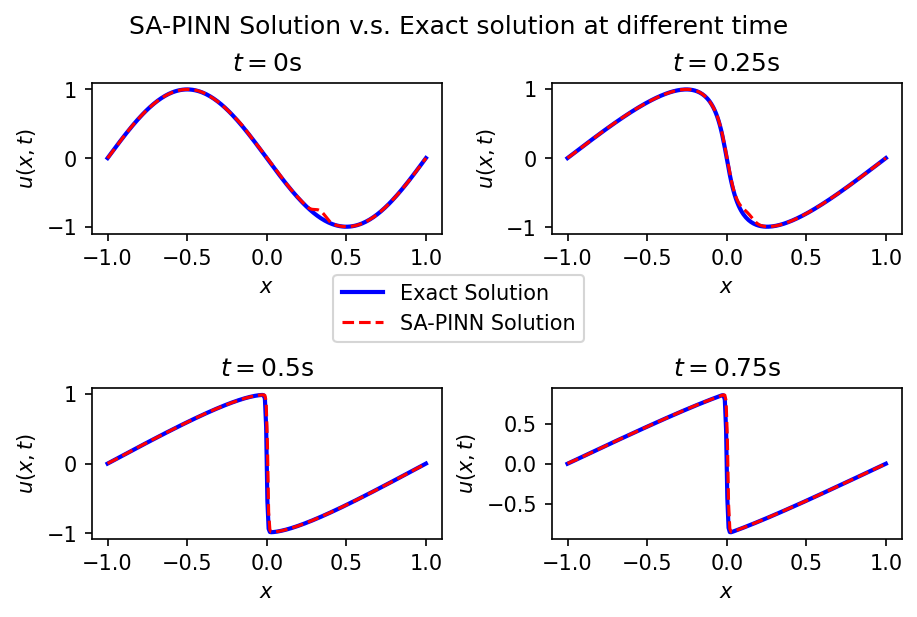

In [ ]:
fig, axs = plt.subplots(2, 2, layout="constrained", dpi=150, gridspec_kw={'hspace': 0.2})
axs[0, 0].plot(x, usol.T[0, :], 'b-', linewidth = 2, label="Exact Solution")
axs[0, 0].plot(x, u_pred.T[0, :], 'r--', label="SA-PINN Solution")
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$u(x, t)$')
axs[0, 0].set_title('$t=0$s')

axs[0, 1].plot(x, usol.T[25, :], 'b-', linewidth = 2, label="Exact Solution")
axs[0, 1].plot(x, u_pred.T[25, :], 'r--', label="SA-PINN Solution")
axs[0, 1].set_xlabel('$x$')
axs[0, 1].set_ylabel('$u(x, t)$')
axs[0, 1].set_title('$t=0.25$s')

axs[1, 0].plot(x, usol.T[50, :], 'b-', linewidth = 2, label="Exact Solution")
axs[1, 0].plot(x, u_pred.T[50, :], 'r--', label="SA-PINN Solution")
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$u(x, t)$')
axs[1, 0].set_title('$t=0.5$s')

axs[1, 1].plot(x, usol.T[75, :], 'b-', linewidth = 2, label="Exact Solution")
axs[1, 1].plot(x, u_pred.T[75, :], 'r--', label="SA-PINN Solution")
axs[1, 1].set_xlabel('$x$')
axs[1, 1].set_ylabel('$u(x, t)$')
axs[1, 1].set_title('$t=0.75$s')

handles, labels = axs[1, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center')
# fig.get_layout_engine().set(hspace=0.2, wspace=0.2)
fig.suptitle("SA-PINN Solution v.s. Exact solution at different time")

## Save Model

**Important: You have to use the same dataset as the above dataset to import and use this saved model. Other datasets will cause error and will cause inacurate result.**

Data to save:

- model's layers => layers (use layers to initialize model)
- model's weights => sa_pinn.get_weights()  (use SA_PINN.set_weight() to set new model's weights)
- model's adaptive weights => sa_pinn.u_weights, sa_pinn.f_weights

In [ ]:
import json

data_dict = {
    "layers": layers.tolist(),
    "model_weights": sa_pinn.get_weights().numpy().tolist(),
    "model_adaptive_weights": [sa_pinn.u_weights.numpy().tolist(), sa_pinn.f_weights.numpy().tolist()]
}

data_json = json.dumps(data_dict, indent=4)

with open('SAPINNmodel.json', 'w') as f:
    f.write(data_json)